In [1]:
# Import packages 
import numpy as np
import xarray as xr
from scipy.stats import linregress as _linregress
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gp
import regionmask
from matplotlib.ticker import MultipleLocator
from cartopy.util import add_cyclic_point

In [2]:
def area_weighted_ave(ds):
    if 'lat' not in ds.dims:
        ds = ds.rename({'latitude':'lat','longitude':'lon'})
    coslat = np.cos(np.deg2rad(ds.lat))
    ds,coslat = xr.broadcast(ds,coslat)
    ds = ds * coslat
    #return ds.mean(('lat','lon'),skipna=True)
    return ds.sum(('lat','lon'),skipna=True)/((ds/ds)*coslat).sum(('lat','lon'),skipna=True)


def linregress(da_y, da_x, dim=None):
    '''xarray-wrapped function of scipy.stats.linregress.
    Note the order of the input arguments x, y is reversed to the original scipy function.'''
    if dim is None:
        dim = [d for d in da_y.dims if d in da_x.dims][0]

    slope, intercept, r, p, stderr = xr.apply_ufunc(_linregress, da_x, da_y,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[[], [], [], [], []],
        vectorize=True,
        dask='allowed')
    predicted = da_x * slope + intercept

    slope.attrs['long_name'] = 'slope of the linear regression'
    intercept.attrs['long_name'] = 'intercept of the linear regression'
    r.attrs['long_name'] = 'correlation coefficient'
    p.attrs['long_name'] = 'p-value'
    stderr.attrs['long_name'] = 'standard error of the estimated gradient'
    predicted.attrs['long_name'] = 'predicted values by the linear regression model'

    return xr.Dataset(dict(slope=slope, intercept=intercept,
        r=r, p=p, stderr=stderr, predicted=predicted))


def draw_boxes(lon_min,lon_max,lat_min,lat_max):
    
    box_lon = [lon_min, lon_max, lon_max, lon_min, lon_min]
    box_lat = [lat_min, lat_min, lat_max, lat_max, lat_min]

    # Plot the box using plt.plot (on the same projection)
    ax.plot(box_lon, box_lat, color='k', linestyle='-', linewidth=2, zorder=20, transform=ccrs.PlateCarree())


def convert_longitude(ds):
    """
    Convert longitude from [0, 360] to [-180, 180].
    
    Parameters:
    - lon: array-like, input longitudes in the range [0, 360]
    
    Returns:
    - Converted longitudes in the range [-180, 180]
    """
    ds_new = ds.copy()
    lon = ds['longitude']  # Convert input to a NumPy array if it's not already
    converted_lon = (lon + 180) % 360 - 180  # Apply conversion
    ds_new.coords['longitude'] = converted_lon
    return ds_new.sortby('longitude')


def maskgen(shpfile, dat4mask, regionname):

    maskcoords = xr.Dataset({'latitude' : (['latitude'],dat4mask['latitude'].values)}, {'longitude' : (['longitude'],dat4mask['longitude'].values)})

    mask = np.zeros([maskcoords.latitude.size, maskcoords.longitude.size])

    shpcontents = gp.read_file(shpfile)

    for i in range(0,len(regionname),1):
        #print('masking '+regionname[i])
        try:
            region = shpcontents[shpcontents.NAME_1 == regionname[i]]

        except:
            region = shpcontents[shpcontents.NAME_0 == regionname[i]]
        maskt = regionmask.mask_geopandas(region, maskcoords['longitude'], maskcoords['latitude'])
        maskt = np.where(np.isnan(maskt), 0, 1)
        mask[:,:] = mask[:,:] + maskt[:,:]

    mask = np.where(mask == 0, np.nan, 1)
    mask = xr.DataArray(mask, coords = maskcoords.coords)

    return mask


def get_ee(ds):
    ds_con = convert_longitude(ds)
    return area_weighted_ave(ds_con.sel(longitude=slice(15,40),latitude=slice(36, 70)))

def get_ca(ds): 
    ds_con = convert_longitude(ds)
    return area_weighted_ave(ds_con.sel(longitude=slice(15, 35),latitude=slice(-15, 10)))

### Load Datasets

In [3]:
# ERA5 TXx
era5_700 = xr.open_dataset('/scratch/midway3/krucker01/ERA5/era5_t700_monthly_max_1deg_1980_2023.nc')
era5_700 = era5_700.rename({'lat':'latitude', 'lon':'longitude'}).compute()

era5_850 = xr.open_dataset('/scratch/midway3/krucker01/ERA5/era5_TXx850_1980_2023.nc')
era5_850 = era5_850.rename({'lat':'latitude', 'lon':'longitude'}).compute()
era5_850['latitude'] = era5_700['latitude']
era5_850['longitude'] = era5_700['longitude']

In [5]:
# AMIP monthly max
amip_700 = xr.open_mfdataset("/project/tas1/itbaxter/for-tiffany/amip/180x360/ta/ta700_monthly_max_all_members_180x360.nc")
amip_700['latitude'] = era5_700['latitude']
amip_700['longitude'] = era5_700['longitude']
amip_700 = amip_700.compute()

amip_850 = xr.open_mfdataset("/project/tas1/itbaxter/for-tiffany/amip/180x360/ta/t850_monthly_max_all_members_180x360.nc")
amip_850['latitude'] = era5_700['latitude']
amip_850['longitude'] = era5_700['longitude']
amip_850 = amip_850.compute()

In [7]:
# NGCM TXx
ngcm_700 = xr.open_dataset('/scratch/midway3/krucker01/ai-models/ngcm/TXx_700_ngcm_daily_1981_2023.nc')
ngcm_700 = ngcm_700.compute()
ngcm_700 = ngcm_700.resample(time = '1MS').max('time')

ngcm_850 = xr.open_dataset('/scratch/midway3/krucker01/ai-models/ngcm/tmax_850_ngcm_1981-2023.nc').compute()
ngcm_850 = ngcm_850.to_dataarray(dim = 'member',name = 'TXx850')

In [9]:
# ACE2 TXx

#ace2_700 = xr.open_dataset('/scratch/midway3/krucker01/ai-models/ACE2/ace2_TXx700_yearly_1979_2022.nc').compute()
ace2_700 = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/ACE2_37/ace2_37_TXx700_yearly_1980_2022.nc')
ace2_700 = ace2_700.rename({'lat':'latitude', 'lon':'longitude'})
ace2_700['latitude'] = era5_700['latitude']
ace2_700['longitude'] = era5_700['longitude']

#ace2_850 = xr.open_dataset('/scratch/midway3/krucker01/ai-models/ACE2/ace2_TXx850.nc').compute()
ace2_850 = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/ACE2_37/ace2_37_TXx850_yearly_1980_2022.nc').compute()
ace2_850 = ace2_850.rename({'lat':'latitude','lon':'longitude'})
#ace2_850 = ace2_850.rename({'laitude':'latitude'})
ace2_850['latitude'] = era5_700['latitude']
ace2_850['longitude'] = era5_700['longitude']

In [11]:
# Land sea mask from ERA5
land_sea_mask = xr.open_dataset('/scratch/midway3/krucker01/shp/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc')

#Regrid mask 1 degree
lat01 = land_sea_mask['latitude']
lon01 = land_sea_mask['longitude']

lat28 = era5_700['latitude']
lon28 = era5_700['longitude']

mask_era5_course = land_sea_mask['LSM'][0].interp(latitude=lat28, longitude=lon28)

ocean_mask = xr.where(mask_era5_course, 1, np.nan)
land_mask = xr.where(mask_era5_course, np.nan, 1)

#Regrid mask 2.8 degree
lat01 = land_sea_mask['latitude']
lon01 = land_sea_mask['longitude']

lat28 = ngcm_700['latitude']
lon28 = ngcm_700['longitude']

mask_era5_course = land_sea_mask['LSM'][0].interp(latitude=lat28, longitude=lon28)

ocean_mask_course = xr.where(mask_era5_course, 1, np.nan)
land_mask_course = xr.where(mask_era5_course, np.nan, 1)

In [12]:
# Apply mask 
era5_700_land = ocean_mask*era5_700
amip_700_land = ocean_mask*amip_700
ngcm_700_land = ocean_mask_course*ngcm_700
ace2_700_land = ocean_mask*ace2_700

era5_850_land = ocean_mask*era5_850
amip_850_land = ocean_mask*amip_850
ngcm_850_land = ocean_mask_course*ngcm_850
ace2_850_land = ocean_mask*ace2_850

In [13]:
cesm_700 = amip_700.sel(member_id = ['CESM2-FV2', 'CESM2-WACCM', 'CESM2'])
cesm_700_land = amip_700_land.sel(member_id = ['CESM2-FV2', 'CESM2-WACCM', 'CESM2'])

In [14]:
cesm_850 = amip_850.sel(member_id = ['CESM2-FV2', 'CESM2-WACCM', 'CESM2'])
cesm_850_land = amip_850_land.sel(member_id = ['CESM2-FV2', 'CESM2-WACCM', 'CESM2'])

## Trends 

In [15]:
era5_700_lonavg = ((era5_700_land).groupby('time.year').max('time')).sel(year=slice(1981,2014))
era5_700_trend = (linregress(era5_700_lonavg['T'], era5_700_lonavg['year']).slope)*10

In [16]:
era5_850_lonavg = ((era5_850_land)).sel(year=slice(1981,2014))
era5_850_trend = (linregress(era5_850_lonavg['T'], era5_700_lonavg['year']).slope)*10

In [17]:
amip_700_lonavg = ((amip_700_land).groupby('time.year').max('time')).sel(year=slice(1981,2014))
amip_700_trend = (linregress(amip_700_lonavg['t700'], amip_700_lonavg['year']).slope)*10

In [18]:
amip_850_lonavg = ((amip_850_land).groupby('time.year').max('time')).sel(year=slice(1981,2014))
amip_850_trend = (linregress(amip_850_lonavg['tmax850'], amip_850_lonavg['year']).slope)*10

In [19]:
cesm_700_lonavg = ((cesm_700_land).groupby('time.year').max('time')).sel(year=slice(1981,2014))
cesm_700_trend = (linregress(cesm_700_lonavg['t700'], cesm_700_lonavg['year']).slope)*10

In [20]:
cesm_850_lonavg = ((cesm_850_land).groupby('time.year').max('time')).sel(year=slice(1981,2014))
cesm_850_trend = (linregress(cesm_850_lonavg['tmax850'], cesm_850_lonavg['year']).slope)*10

In [21]:
ngcm_700_lonavg = ((ngcm_700_land).groupby('time.year').max('time')).sel(year=slice(1981,2014))
ngcm_700_trend = (linregress(ngcm_700_lonavg['__xarray_dataarray_variable__'], ngcm_700_lonavg['year']).slope)*10

In [22]:
ngcm_850_lonavg = (ngcm_850_land.groupby('time.year').max('time')).sel(year=slice(1981,2014))
ngcm_850_trend = (linregress(ngcm_850_lonavg,ngcm_850_lonavg['year']).slope)*10

In [23]:
ace2_700_lonavg = ace2_700_land.sel(year=slice(1981,2014))
ace2_700_trend = (linregress(ace2_700_lonavg['TXx700'],ace2_700_lonavg['year']).slope)*10

In [24]:
ace2_850_lonavg = ace2_850_land.sel(year=slice(1981,2014))
ace2_850_trend = (linregress(ace2_850_lonavg['TXx850'],ace2_850_lonavg['year']).slope)*10

In [25]:
# Mask MWUS
mus_mask = xr.open_dataset('/scratch/midway3/itbaxter/MAPP_HumidityTrends/land_humidity_trends/manuscript/qtrendutils/hadex_mus_mask.nc')['mask']
mus_mask_1deg = xr.open_dataset('/scratch/midway3/itbaxter/MAPP_HumidityTrends/land_humidity_trends/manuscript/qtrendutils/mus_mask_180x360.nc')['mask']
mus_mask_1deg = mus_mask_1deg.rename({'lat':'latitude','lon':'longitude'})
mus_mask_1deg['latitude'] = era5_700['latitude']
mus_mask_1deg['longitude'] = era5_700['longitude']
mus_mask_ngcm = xr.open_dataset('/scratch/midway3/itbaxter/MAPP_HumidityTrends/land_humidity_trends/manuscript/qtrendutils/mus_mask_ngcm.nc')['mask']
mus_mask_ngcm = mus_mask_ngcm.rename({'lat':'latitude','lon':'longitude'})
mus_mask_ngcm['latitude'] = ngcm_700['latitude']
mus_mask_ngcm['longitude'] = ngcm_700['longitude']

In [27]:
# Mask SWUS
# USA mask
shpfile = "/scratch/midway3/krucker01/shp/gadm36_USA_1.shp"
states = ['California','Nevada','Utah','Arizona','New Mexico','Colorado']

mask_era5 = maskgen(shpfile, era5_700, states)

mask_amip = maskgen(shpfile, amip_700, states)

mask_ngcm = maskgen(shpfile, ngcm_700, states)

mask_ace2 = maskgen(shpfile, ace2_700, states)

masking California
masking Nevada
masking Utah
masking Arizona
masking New Mexico
masking Colorado
masking California
masking Nevada
masking Utah
masking Arizona
masking New Mexico
masking Colorado
masking California
masking Nevada
masking Utah
masking Arizona
masking New Mexico
masking Colorado
masking California
masking Nevada
masking Utah
masking Arizona
masking New Mexico
masking Colorado


### Regional Time Series

In [29]:
# ERA5 Eastern Europe
era5_850_ee = get_ee(era5_850_land.sel(year = slice(1980,2023)))
era5_850_ee_norm = era5_850_ee-(era5_850_ee.sel(year = slice(1980,1990)).mean().T)

In [30]:
# AMIP Eastern Europe
amip_850_ee = get_ee(amip_850_land.groupby('time.year').max('time').mean('member_id'))
amip_850_ee_norm = amip_850_ee-(amip_850_ee.sel(year=slice(1980,1990)).mean().tmax850)

In [31]:
# NGCM Eastern Europe
ngcm_850_ee = get_ee(ngcm_850_land.groupby('time.year').max('time').mean('member'))
ngcm_850_ee_norm = ngcm_850_ee-(ngcm_850_ee.sel(year=slice(1980,1990)).mean())

In [32]:
# ACE2 Eastern Europe
ace2_850_ee = get_ee(ace2_850_land.mean('member_id')).sel(year = slice(1981,2021))
ace2_850_ee_norm = ace2_850_ee-(ace2_850_ee.sel(year=slice(1980,1990)).mean().TXx850)

In [33]:
# ERA5 Southwest US
era5_700_sw = area_weighted_ave(era5_700_land.groupby('time.year').max('time').where(mask_era5==1))
era5_700_sw_norm = era5_700_sw-(era5_700_sw.sel(year=slice(1980,1990)).mean().T)

In [34]:
# AMIP Southwest US
amip_700_sw = area_weighted_ave(amip_700_land.groupby('time.year').max('time').mean('member_id').where(mask_amip==1))
amip_700_sw_norm = amip_700_sw-(amip_700_sw.sel(year=slice(1980,1990)).mean().t700)

In [35]:
# NGCM Southwest US
ngcm_700_sw = area_weighted_ave(ngcm_700_land.groupby('time.year').max('time').mean('member').where(mask_ngcm==1))
ngcm_700_sw_norm = ngcm_700_sw-(ngcm_700_sw.sel(year=slice(1980,1990)).mean().__xarray_dataarray_variable__)

In [36]:
# ACE2 Southwest US
ace2_700_sw = area_weighted_ave(ace2_700_land.mean('member_id').where(mask_ace2==1)).sel(year = slice(1981,2021))
ace2_700_sw_norm = ace2_700_sw-(ace2_700_sw.sel(year=slice(1980,1990)).mean().TXx700)

In [37]:
# ERA5 Midwest US
era5_850_mwus = area_weighted_ave(era5_850_land.where(mus_mask_1deg==1))
era5_850_mwus_norm = era5_850_mwus-(era5_850_mwus.sel(year=slice(1980,1990)).mean().T)

In [38]:
# AMIP Midwest US
amip_850_mwus = area_weighted_ave(amip_850_land.groupby('time.year').max('time').mean('member_id').where(mus_mask_1deg==1))
amip_850_mwus_norm = amip_850_mwus-(amip_850_mwus.sel(year=slice(1980,1990)).mean().tmax850)

In [39]:
# NGCM Midwest US
ngcm_850_mwus = area_weighted_ave(ngcm_850_land.groupby('time.year').max('time').mean('member').where(mus_mask_ngcm==1))
ngcm_850_mwus_norm = ngcm_850_mwus-(ngcm_850_mwus.sel(year=slice(1980,1990)).mean())

In [40]:
# ACE2 Midwest US
ace2_850_mwus = area_weighted_ave(ace2_850_land.mean('member_id').where(mus_mask_1deg==1)).sel(year = slice(1981,2021))
ace2_850_mwus_norm = ace2_850_mwus-(ace2_850_mwus.sel(year=slice(1980,1990)).mean().TXx850)

In [51]:
# ERA5 Central Africa
era5_850_ca = get_ca(era5_850_land.sel(year = slice(1980,2023)))
era5_850_ca_norm = era5_850_ca-(era5_850_ca.sel(year = slice(1980,1990)).mean().T)

In [52]:
# AMIP Central Africa
amip_850_ca = get_ca(amip_850_land.groupby('time.year').max('time').mean('member_id'))
amip_850_ca_norm = amip_850_ca-(amip_850_ca.sel(year=slice(1980,1990)).mean().tmax850)

In [53]:
# NGCM Central Africa
ngcm_850_ca = get_ca(ngcm_850_land.groupby('time.year').max('time').mean('member'))
ngcm_850_ca_norm = ngcm_850_ca-(ngcm_850_ca.sel(year=slice(1980,1990)).mean())

In [54]:
# ACE2 Central Africa 
ace2_850_ca = get_ca(ace2_850_land.mean('member_id')).sel(year = slice(1981,2021))
ace2_850_ca_norm = ace2_850_ca-(ace2_850_ca.sel(year=slice(1980,1990)).mean().TXx850)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


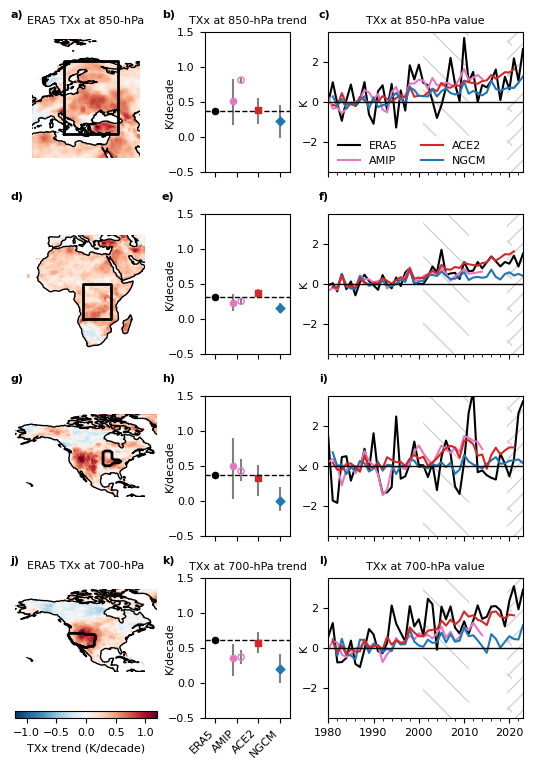

In [55]:
# Plot, getting trend for each region

fig = plt.figure(figsize = (4.75,7))
plt.axis('off')

levels = np.arange(-1.2,1.21,step=0.025)
shrink = 1
fontsize = 8
cbar_loc = 'bottom'
ssize = 20
height = 0.2
boxp_width = 0.18
time_width = 0.41
map_width = 0.3
map_height = 0.25
pad = -5
plt.rcParams['hatch.color'] = 'lightgray' 

lat = era5_850_trend['latitude']
lon = era5_850_trend['longitude']


datas,lons = add_cyclic_point(era5_850_trend,lon)


# Eastern Europe
ax = fig.add_axes([0,0.8,map_width,map_height-0.08], projection=ccrs.PlateCarree())

plot = ax.contourf(lon, lat, era5_850_trend, transform=ccrs.PlateCarree(),
                   cmap='RdBu_r', levels = levels)

draw_boxes(15,40, 36, 70)
ax.set_extent([0,50, 25, 80], crs = ccrs.PlateCarree())
ax.coastlines()
ax.set_title('ERA5 TXx at 850-hPa', fontsize = fontsize, pad = 11)
ax.spines[:].set_visible(False)

# Eastern Europe Boxplot
ax = fig.add_axes([0.4,0.78,boxp_width,height])
ax.scatter([0], get_ee(era5_850_trend).values, label = 'ERA5', c = 'k', s = ssize)
amip_ee = get_ee(amip_850_trend).values
cesm_ee = get_ee(cesm_850_trend).values
ngcm_ee = get_ee(ngcm_850_trend).values
ace2_ee = get_ee(ace2_850_trend).values

ax.scatter([0.8], amip_ee.mean(), color = '#E377C2', marker = 'o', s = ssize)
ax.vlines([0.8], ymin = np.quantile(amip_ee, 0.05), ymax = np.quantile(amip_ee, 0.95), zorder = -2, color = 'grey')
ax.scatter([1.2], cesm_ee.mean(), color = '#E377C2', marker = 'o', s = ssize, facecolor = 'none')
ax.vlines([1.2], ymin = np.quantile(cesm_ee, 0.05), ymax = np.quantile(cesm_ee, 0.95), zorder = -2, color = 'grey')
ax.scatter([2], ace2_ee.mean(), color = '#D62728', marker = 's', s = ssize)
ax.vlines([2], ymin = np.quantile(ace2_ee, 0.05), ymax = np.quantile(ace2_ee, 0.95), zorder = -2, color = 'grey')
ax.scatter([3], ngcm_ee.mean(), color = '#1F77B4', marker = 'D', s = ssize)
ax.vlines([3], ymin = np.quantile(ngcm_ee, 0.05), ymax = np.quantile(ngcm_ee, 0.95), zorder = -2, color = 'grey')


ax.set_title('TXx at 850-hPa trend', fontsize = fontsize)
ax.axhline(get_ee(era5_850_trend).values, color = 'k', linestyle = '--', linewidth = 1, zorder = -2)
ax.set_ylim([-0.5,1.5])
ax.set_ylabel('K/decade', fontsize = fontsize, labelpad = pad)
ax.set_yticks([-0.5,0.0,0.5,1.0,1.5])
ax.set_xlim([-0.5,3.5])
ax.set_xticks([0,1,2,3])
ax.tick_params(axis='both', labelsize=fontsize)
ax.set_xticklabels([])


#Time series
ax = fig.add_axes([0.66,0.78,time_width,height])
ax.plot(era5_850_ee_norm.year, era5_850_ee_norm.T, color = 'k', label = "ERA5")
ax.plot(amip_850_ee_norm.year, amip_850_ee_norm.tmax850, color = '#E377C2', label = 'AMIP')
ax.plot(ace2_850_ca_norm.year, ace2_850_ca_norm.TXx850, color = '#D62728', label = "ACE2")
ax.plot(ngcm_850_ee_norm.year, ngcm_850_ee_norm, color = '#1F77B4', label = "NGCM")
ax.legend(bbox_to_anchor = (0,-0.03), loc = 'lower left', edgecolor = 'none', fontsize = fontsize, ncol = 2)


plt.axvspan(2001, 2011, facecolor='none', hatch = "\\")
plt.axvspan(2020-0.5, 2020+0.5, facecolor='none', hatch = '\\')
plt.axvspan(2020-0.5,2024, facecolor = 'none', hatch = '//')

ax.set_title('TXx at 850-hPa value', fontsize = fontsize)
ax.axhline(0,color = 'k', linewidth = 1)
ax.set_xlim([1980,2023])
ax.set_ylim([-3.5,3.5])
#ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_xticks([1980,1990,2000,2010,2020])
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.set_xticklabels([])
ax.set_ylabel('K', fontsize = fontsize, labelpad = pad)
ax.tick_params(axis='both', labelsize=fontsize)

# Southwest US
ax = fig.add_axes([0,0,map_width,map_height], projection=ccrs.PlateCarree()) #[0.01,0.56,0.25,0.19]
plot = ax.contourf(lon, lat, era5_700_trend, transform=ccrs.PlateCarree(),
                   cmap='RdBu_r', levels = levels)


plt.contour(mask_era5.longitude, mask_era5.latitude, np.nan_to_num(mask_era5), colors = 'k', linewidths = 2, levels = [0,1])
ax.set_title('ERA5 TXx at 700-hPa', fontsize = fontsize, pad = 14.1)

ax.set_extent([-170,-50,10,80], crs = ccrs.PlateCarree())
ax.coastlines()
ax.spines[:].set_visible(False)

# Southwest US Boxplot
ax = fig.add_axes([0.4,0,boxp_width,height]) #([0.35,0.56,0.15,0.19])
ax.scatter([0], area_weighted_ave((era5_700_trend).where(mask_era5 == 1)).values, label = 'ERA5', c = 'k', s = ssize)
amip_sw = area_weighted_ave((amip_700_trend).where(mask_amip == 1)).values
cesm_sw = area_weighted_ave((cesm_700_trend).where(mask_amip == 1)).values
ngcm_sw = area_weighted_ave((ngcm_700_trend).where(mask_ngcm == 1)).values
ace2_sw = area_weighted_ave((ace2_700_trend).where(mask_ace2 == 1)).values

ax.scatter([0.8], amip_sw.mean(), color = '#E377C2', marker = 'o', s = ssize)
ax.vlines([0.8], ymin = np.quantile(amip_sw, 0.05), ymax = np.quantile(amip_sw, 0.95), zorder = -2, color = 'grey')
ax.scatter([1.2], cesm_sw.mean(), color = '#E377C2', marker = 'o', s = ssize, facecolor = 'none')
ax.vlines([1.2], ymin = np.quantile(cesm_sw, 0.05), ymax = np.quantile(cesm_sw, 0.95), zorder = -2, color = 'grey')
ax.scatter([2], ace2_sw.mean(), color = '#D62728', marker = 's', s = ssize)
ax.vlines([2], ymin = np.quantile(ace2_sw, 0.05), ymax = np.quantile(ace2_sw, 0.95), zorder = -2, color = 'grey')
ax.scatter([3], ngcm_sw.mean(), color = '#1F77B4', marker = 'D', s = ssize)
ax.vlines([3], ymin = np.quantile(ngcm_sw, 0.05), ymax = np.quantile(ngcm_sw, 0.95), zorder = -2, color = 'grey')
ax.axhline(area_weighted_ave((era5_700_trend).where(mask_era5 == 1)).values, color = 'k', linestyle = '--', linewidth = 1, zorder = -2)

ax.set_ylim([-0.5,1.5])
ax.set_xlim([-0.5,3.5])
ax.set_xticks([0,1,2,3])
ax.set_title('TXx at 700-hPa trend', fontsize = fontsize)
ax.set_ylabel('K/decade', fontsize = fontsize, labelpad = pad)
ax.tick_params(axis='both', labelsize=fontsize)
ax.set_yticks([-0.5,0.0,0.5,1.0,1.5])
ax.set_xticklabels(['ERA5','AMIP','ACE2','NGCM'], fontsize = fontsize)
plt.xticks(rotation = 45, ha ='right')


#Time series
ax = fig.add_axes([0.66,0,time_width,height])#([0.59,0.56,0.4,0.19])
ax.plot(era5_700_sw_norm.year, era5_700_sw_norm.T, color = 'k')
ax.plot(amip_700_sw_norm.year, amip_700_sw_norm.t700, color = '#E377C2')
ax.plot(ngcm_700_sw_norm.year, ngcm_700_sw_norm.__xarray_dataarray_variable__, color = '#1F77B4')
ax.plot(ace2_700_sw_norm.year, ace2_700_sw_norm.TXx700, color = '#D62728')

ax.set_title('TXx at 700-hPa value', fontsize = fontsize)

plt.axvspan(2001, 2011, facecolor='none', hatch = "\\")
plt.axvspan(2020-0.5, 2020+0.5, facecolor='none', hatch = '\\')
plt.axvspan(2020-0.5,2024, facecolor = 'none', hatch = '//')


ax.axhline(0,color = 'k', linewidth = 1)
ax.set_xlim([1980,2023])
ax.set_ylim([-3.5,3.5])
#ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_xticks([1980,1990,2000,2010,2020])
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.set_ylabel('K', fontsize = fontsize, labelpad = pad)
ax.tick_params(axis='both', labelsize=fontsize)


# Midwest US
ax = fig.add_axes([0,0.25,map_width,map_height], projection=ccrs.PlateCarree())
plot = ax.contourf(lon, lat, era5_850_trend, transform=ccrs.PlateCarree(),
                   cmap='RdBu_r', levels = levels)

ax.contour(mus_mask['lon'],mus_mask['lat'],mus_mask.fillna(0),
           levels=[0.5],
           colors='k',
           transform=ccrs.PlateCarree(),
           linewidths=2,
           )
ax.set_extent([-170,-50,10,80], crs = ccrs.PlateCarree())
ax.coastlines()
ax.spines[:].set_visible(False)

#Midwest US boxplot 
ax = fig.add_axes([0.4,0.26,boxp_width,height])
ax.scatter([0], area_weighted_ave(era5_850_trend.where(mus_mask_1deg == 1)).values, color = 'k', s = ssize)
ngcm_mwus = area_weighted_ave(ngcm_850_trend.where(mus_mask_ngcm == 1)).values
amip_mwus = area_weighted_ave(amip_850_trend.where(mus_mask_1deg == 1)).values
cesm_mwus = area_weighted_ave(cesm_850_trend.where(mus_mask_1deg == 1)).values
ace2_mwus = area_weighted_ave(ace2_850_trend.where(mus_mask_1deg == 1)).values

ax.scatter([0.8], amip_mwus.mean(), color = '#E377C2', marker = 'o', s = ssize)
ax.vlines([0.8], ymin = np.quantile(amip_mwus, 0.05), ymax = np.quantile(amip_mwus, 0.95), zorder = -2, color = 'grey')
ax.scatter([1.2], cesm_mwus.mean(), color = '#E377C2', marker = 'o', s = ssize, facecolor = 'none')
ax.vlines([1.2], ymin = np.quantile(cesm_mwus, 0.05), ymax = np.quantile(cesm_mwus, 0.95), zorder = -2, color = 'grey')
ax.scatter([2], ace2_mwus.mean(), color = '#D62728', marker = 's', s = ssize)
ax.vlines([2], ymin = np.quantile(ace2_mwus, 0.05), ymax = np.quantile(ace2_mwus, 0.95), zorder = -2, color = 'grey')
ax.scatter([3], ngcm_mwus.mean(), color = '#1F77B4', marker = 'D', s = ssize)
ax.vlines([3], ymin = np.quantile(ngcm_mwus, 0.05), ymax = np.quantile(ngcm_mwus, 0.95), zorder = -2, color = 'grey')


ax.axhline(area_weighted_ave(era5_850_trend.where(mus_mask_1deg == 1)).values, linestyle='--', color='k', linewidth=1)
ax.set_ylim([-0.5,1.5])
ax.set_ylabel('K/decade', fontsize = fontsize, labelpad = pad)
ax.set_xlim([-0.5,3.5])
ax.set_xticks([0,1,2,3])
ax.set_yticks([-0.5,0.0,0.5,1.0,1.5])
ax.set_xticklabels([])
ax.tick_params(axis='both', labelsize=fontsize)

# Colorbar
cb_ax = fig.add_axes([0,0,map_width,0.01])
cbar = fig.colorbar(plot, ax=ax, ticks = levels, shrink = shrink, orientation = 'horizontal', cax = cb_ax)
cbar.set_ticks([-1,-0.5,0,0.5,1])
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label('TXx trend (K/decade)', size=fontsize)

#Time series
ax = fig.add_axes([0.66,0.26,time_width,height])
ax.plot(era5_850_mwus_norm.year, era5_850_mwus_norm.T, color = 'k')
ax.plot(amip_850_mwus_norm.year, amip_850_mwus_norm.tmax850, color = '#E377C2')
ax.plot(ngcm_850_mwus_norm.year, ngcm_850_mwus_norm, color = '#1F77B4')
ax.plot(ace2_850_mwus_norm.year, ace2_850_mwus_norm.TXx850, color = '#D62728')


plt.axvspan(2001, 2011, facecolor='none', hatch = "\\")
plt.axvspan(2020-0.5, 2020+0.5, facecolor='none', hatch = '\\')
plt.axvspan(2020-0.5,2024, facecolor = 'none', hatch = '//')

ax.axhline(0,color = 'k', linewidth = 1)
ax.set_xlim([1980,2023])
ax.set_ylim([-3.5,3.5])
#ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_xticks([1980,1990,2000,2010,2020])
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.set_xticklabels([])
ax.set_ylabel('K', fontsize = fontsize, labelpad = pad)
ax.tick_params(axis='both', labelsize=fontsize)

# Central Africa
ax = fig.add_axes([0,0.52,map_width,map_height-0.08], projection=ccrs.PlateCarree()) #[0.01,0.06,0.25,0.19]

plot = ax.contourf(lons, lat, datas, transform=ccrs.PlateCarree(),
                   cmap='RdBu_r', levels = levels)

draw_boxes(15, 35,-15, 10)
ax.set_extent([-25,60,-40, 45], crs = ccrs.PlateCarree())
ax.coastlines()
ax.spines[:].set_visible(False)

# Central Africa Boxplot
ax = fig.add_axes([0.4,0.52,boxp_width,height])#([0.35,0.06,0.15,0.19])
ax.scatter([0], get_ca(era5_850_trend).values, label = 'ERA5', c = 'k', s = ssize)
amip_ca = get_ca(amip_850_trend).values
cesm_ca = get_ca(cesm_850_trend).values
ngcm_ca = get_ca(ngcm_850_trend).values
ace2_ca = get_ca(ace2_850_trend).values

ax.scatter([0.8], amip_ca.mean(), color = '#E377C2', marker = 'o', s = ssize)
ax.vlines([0.8], ymin = np.quantile(amip_ca, 0.05), ymax = np.quantile(amip_ca, 0.95), zorder = -2, color = 'grey')
ax.scatter([1.2], cesm_ca.mean(), color = '#E377C2', marker = 'o', s = ssize, facecolor = 'none')
ax.vlines([1.2], ymin = np.quantile(cesm_ca, 0.05), ymax = np.quantile(cesm_ca, 0.95), zorder = -2, color = 'grey')
ax.scatter([2], ace2_ca.mean(), color = '#D62728', marker = 's', s = ssize)
ax.vlines([2], ymin = np.quantile(ace2_ca, 0.05), ymax = np.quantile(ace2_ca, 0.95), zorder = -2, color = 'grey')
ax.scatter([3], ngcm_ca.mean(), color = '#1F77B4', marker = 'D', s = ssize)
ax.vlines([3], ymin = np.quantile(ngcm_ca, 0.05), ymax = np.quantile(ngcm_ca, 0.95), zorder = -2, color = 'grey')
ax.axhline(get_ca(era5_850_trend).values, color = 'k', linestyle = '--', linewidth = 1, zorder = -2)

ax.set_ylim([-0.5,1.5])
ax.set_ylabel('K/decade', fontsize = fontsize, labelpad = pad)
ax.tick_params(axis='both', labelsize=fontsize)
ax.set_yticks([-0.5,0.0,0.5,1.0,1.5])
ax.set_xlim([-0.5,3.5])
ax.set_xticks([0,1,2,3])
ax.set_xticklabels([])


#Time series


ax = fig.add_axes([0.66,0.52,time_width,height])#([0.59,0.06,0.4,0.19])
ax.plot(era5_850_ca_norm.year, era5_850_ca_norm.T, color = 'k', label = "ERA5")
ax.plot(amip_850_ca_norm.year, amip_850_ca_norm.tmax850, color = '#E377C2', label = "AMIP")
ax.plot(ngcm_850_ca_norm.year, ngcm_850_ca_norm, color = '#1F77B4', label = "NGCM")
ax.plot(ace2_850_ca_norm.year, ace2_850_ca_norm.TXx850, color = '#D62728')

plt.axvspan(2001, 2011, facecolor='none', hatch = "\\")
plt.axvspan(2020-0.5, 2020+0.5, facecolor='none', hatch = '\\')
plt.axvspan(2020-0.5,2024, facecolor = 'none', hatch = '//')

ax.axhline(0,color = 'k', linewidth = 1)
ax.set_xlim([1980,2023])
ax.set_ylim([-3.5,3.5])
#ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_xticks([1980,1990,2000,2010,2020])
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.set_xticklabels([])
ax.set_ylabel('K', fontsize = fontsize, labelpad = pad)
ax.tick_params(axis='both', labelsize=fontsize)


plt.rc('font', size=fontsize)
fig.text(-0.01,1, 'a)', weight = 'bold')
fig.text(0.31,1, 'b)', weight = 'bold')
fig.text(0.64,1, 'c)', weight = 'bold')
fig.text(-0.01,0.74, 'd)', weight = 'bold')
fig.text(0.31,.74, 'e)', weight = 'bold')
fig.text(0.64,.74, 'f)', weight = 'bold')
fig.text(-0.01,0.48, 'g)', weight = 'bold')
fig.text(0.31,0.48, 'h)', weight = 'bold')
fig.text(0.64,0.48, 'i)', weight = 'bold')
fig.text(-0.01,0.22, 'j)', weight = 'bold')
fig.text(0.31,0.22, 'k)', weight = 'bold')
fig.text(0.64,0.22, 'l)', weight = 'bold')


plt.savefig('Thermo_Fig_3_700.eps', dpi = 600, bbox_inches='tight')